# Analysis AC thresholds (better ear)

01-07-2023 Guido Cattani

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import shapiro as shapiro

In [2]:
# read measured thresholds
def read_AC_thresholds():
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Primary_data/AC_measured_thresholds.csv'
    p_in = Path(f_in)   
    df = pd.read_csv(p_in)
    df = df.drop(columns='Study_ID')
    new_names = {
             'AC_125':'AC_125_Hz', 'AC_250':'AC_250_Hz', 'AC_500':'AC_500_Hz', 
             'AC_1000': 'AC_1000_Hz', 'AC_2000': 'AC_2000_Hz', 
             'AC_4000': 'AC_4000_Hz', 'AC_8000': 'AC_8000_Hz'}
    df.rename(mapper=new_names, axis=1, inplace=True) 
    df = df.fillna(pd.NA)
    return df

In [3]:
def present_AC_thresholds():
    ac = read_AC_thresholds()
    ac1 = ac[['AC_500_Hz', 'AC_1000_Hz', 'AC_2000_Hz', 'AC_4000_Hz']].copy()
    ac1 = ac1.dropna()
    pta = ac1.iloc[:, 1:].mean(axis='columns').round(1)
    ac1.insert(4, column= 'PTA (0.5-4 kHz)', value=pta)
    pta_hf = ac1.iloc[:, 2:].mean(axis='columns').round(1)
    ac1.insert(5, column= 'PTA_HF (1-4 kHz)', value=pta_hf)
    ac1.insert(0, column= 'AC_250_Hz', value=ac[['AC_250_Hz']].copy())
    ac1 = ac1.round(1)
    return ac1

In [4]:
def descriptive_stat(df):
    # calculate quantiles
    quantiles = df.quantile([0.1, 0.5, 0.9]).round(1)
    quantiles.index = ['P10', 'P50', 'P90']
 
    # calculate mean and standard deviation
    mean_values = (pd.DataFrame({'Mean': df.mean().round(1)})).T
    std_values = (pd.DataFrame({'St. dev.': df.std().round(1)})).T

    # perform Shapiro test 
    sht = shapiro_test_norm(df)

    # combine results into a single DataFrame
    res = pd.concat([quantiles, mean_values, std_values, sht])
    
    return res.round(1)

In [5]:
def shapiro_test_norm(df):
    # check normality with Shapiro-Wilk test
    shapiro_result = df.apply(lambda x: shapiro(x) if len(x) >= 3 else (float('nan'), float('nan')))
    
    shapiro_stats = shapiro_result.apply(lambda x: round(x[0], 3))
    p_values = shapiro_result.apply(lambda x: round(x[1], 3))
    is_normal = p_values >= 0.05
    
    shapiro_test = pd.DataFrame({
        'Shapiro test statistic': shapiro_stats,
        'p-value': p_values,
        'normally distributed': is_normal
    }).transpose()
    
    return shapiro_test

In [6]:
def dict_of_columns(df):
    # makes a dict to rename columns
    clmns_dict = dict()
    names = list(df.columns)
    for i in range(len(df.columns)):
        d = {i : names[i]}
        clmns_dict.update(d)
    return clmns_dict

In [7]:
act = present_AC_thresholds()
act

,AC_250_Hz,AC_500_Hz,AC_1000_Hz,AC_2000_Hz,AC_4000_Hz,PTA (0.5-4 kHz),PTA_HF (1-4 kHz)
0,10,5,5,10,40,18.3,22.8
1,5,15,15,15,55,28.3,32.8
2,15,15,10,0,35,15.0,16.7
3,5,5,10,15,15,13.3,14.4
4,10,0,0,0,15,5.0,6.7
5,30,20,10,10,10,10.0,10.0
6,10,15,10,15,35,20.0,23.3
7,15,15,15,25,60,33.3,39.4
8,5,10,15,5,20,13.3,12.8
9,5,5,0,10,25,11.7,15.6


In [8]:
# calculation quantiles 10, 50, 90
quantiles = [0.10, 0.50, 0.90]
q = act.quantile(q=quantiles).round(1)
q.reset_index(drop=True, inplace=True)
diq = {0:'P10', 1:'P50', 2:'P90'} 
q = q.rename(index=diq)
q = q.reindex(['P10', 'P50', 'P90'])

In [9]:
des_stat = descriptive_stat(act)
des_stat

,AC_250_Hz,AC_500_Hz,AC_1000_Hz,AC_2000_Hz,AC_4000_Hz,PTA (0.5-4 kHz),PTA_HF (1-4 kHz)
P10,5.0,4.5,0.0,4.5,10.0,9.8,9.3
P50,10.0,10.0,10.0,10.0,20.0,13.3,15.0
P90,15.5,20.0,15.0,20.5,41.5,22.4,27.8
Mean,10.5,9.8,8.8,12.2,24.5,15.2,17.3
St. dev.,6.3,6.4,5.1,7.3,14.5,6.7,8.3
Shapiro test statistic,0.784,0.902,0.868,0.924,0.891,0.899,0.89
p-value,0.0,0.046,0.011,0.116,0.028,0.039,0.027
normally distributed,False,False,False,True,False,False,False


In [10]:
# write to csv file
des_stat.to_csv("/media/guido/LACIE/Cingle_Guido/Master/Implant/Analysis_Results/analysis_AC_thresholds.csv")

In [11]:
thr = act.iloc[ : , :5]

In [12]:
# convert Pandas object in numpy array
frqc = np. array([250, 500, 1000, 2000, 4000] , dtype=int)

t = thr.T.to_numpy()

p10 = q.iloc[0, :5].T.to_numpy()
median = q.iloc[1, :5].T.to_numpy()
p90 = q.iloc[2, :5].T.to_numpy()

[]

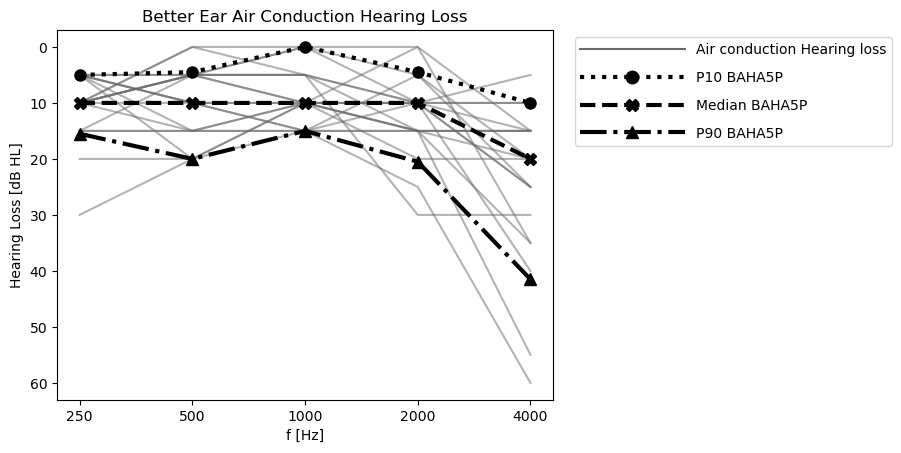

In [13]:
# matplotlib line graph of output BAHA5P

fig, ax = plt.subplots()

ax.set(xlabel='f [Hz]', ylabel='Hearing Loss [dB HL]',
       title='Better Ear Air Conduction Hearing Loss')

ax.set_xscale('log')
ax.set_xticks([250, 500, 1000, 2000, 4000])
ax.set_xticklabels(['250', '500', '1000', '2000', '4000'])
ax.minorticks_off()
ax.invert_yaxis()

# plot lines based on numpy arrays
ax.plot(frqc, t, color="dimgrey", alpha=0.5, label='Air conduction Hearing loss')
ax.plot(frqc, median, color='black', marker='X', linestyle='dashed', linewidth=3, markersize=8)
ax.plot(frqc, p10, color='black', marker='o', linestyle='dotted', linewidth=3, markersize=8)
ax.plot(frqc, p90, color='black', marker='^', linestyle='dashdot', linewidth=3, markersize=8)

# make a legend
leg_line = mlines.Line2D([], [], color="dimgrey", label='Air conduction Hearing loss')
leg_p90 = mlines.Line2D([], [], color='black', marker='^', linestyle='dashdot', 
                            linewidth=3, markersize=9, label='P90 BAHA5P')
leg_med = mlines.Line2D([], [], color='black', marker='X', linestyle='dashed', 
                            linewidth=3, markersize=9, label='Median BAHA5P')
leg_p10 = mlines.Line2D([], [], color='black', marker='o', linestyle='dotted', 
                            linewidth=3, markersize=9, label='P10 BAHA5P')

plt.legend(handles=[leg_line, leg_p10, leg_med, leg_p90], bbox_to_anchor=(1.03, 1), 
                        loc='upper left', labelspacing=1.,handlelength=7.5)

# save the figure
plt.savefig('/media/guido/LACIE/Cingle_Guido/Master/Implant/Analysis_Graphs/AC_thresholds.tiff', 
            transparent=False, dpi=500, bbox_inches="tight")

# plot the figure
plt.plot()